## Dependencies

In [2]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [7]:
chars = sorted(set("".join(words)))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c, i  in ctoi.items()}
Vocab_size = len(itoc)
itoc, Vocab_size

({1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 27)

In [8]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = ctoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) 
B1 = torch.randn(n_hidden, generator=gen)
W2 = torch.randn((n_hidden, Vocab_size), generator=gen)
B2 = torch.randn((Vocab_size), generator=gen)

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 11897


In [10]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    

      0/ 200000: 27.8817
  10000/ 200000: 2.9875
  20000/ 200000: 2.5863
  30000/ 200000: 2.9137
  40000/ 200000: 2.0852
  50000/ 200000: 2.4983
  60000/ 200000: 2.4356
  70000/ 200000: 2.1213
  80000/ 200000: 2.3373
  90000/ 200000: 2.3372
 100000/ 200000: 2.0447
 110000/ 200000: 2.4114
 120000/ 200000: 1.9798
 130000/ 200000: 2.4171
 140000/ 200000: 2.2140
 150000/ 200000: 2.1659
 160000/ 200000: 2.1255
 170000/ 200000: 1.8500
 180000/ 200000: 1.9983
 190000/ 200000: 1.8452


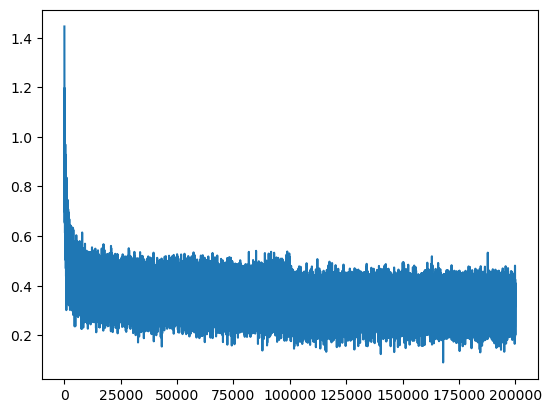

In [11]:
plt.plot(losses)

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.126461982727051
dev 2.1704444885253906


In [17]:
for i in range(10):
    out = []
    context = [0] * block_size
    
    while True:
        embd = Cntx[torch.tensor([context])]
        embcat = embd.view(1, -1)
        hpreact = (embcat @ W1) + B1
        h = torch.tanh(hpreact)
        logits = (h @ W2) + B2
        prob = F.softmax(logits, dim=1)
        
        idx = torch.multinomial(prob, num_samples=1 ,generator=gen).item()
        out.append(itoc[idx])
        context = context[1:] + [idx]
        
        if idx == 0:
            break
    
    print(''.join(out))

bryxlee.
razcarolyn.
atelly.
nishacey.
sumarline.
kayya.
tarah.
everell.
alayel.
adabelle.


## Bring logits near to zero

In [ ]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd), generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) 
B1 = torch.randn(n_hidden, generator=gen)
W2 = torch.randn((n_hidden, Vocab_size), generator=gen)  * 0.01
B2 = torch.randn((Vocab_size), generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 11897


In [25]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


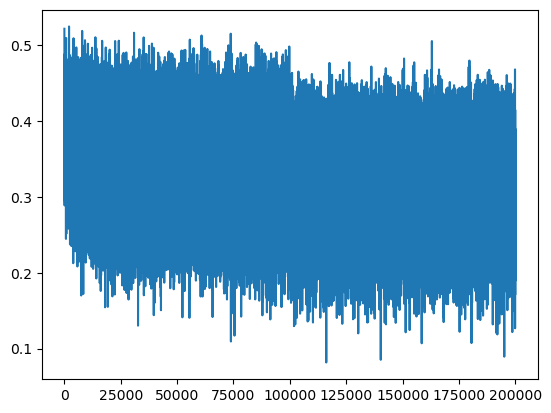

In [26]:
plt.plot(losses)

In [27]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.069589376449585
dev 2.131075382232666


(array([  1.,   0.,   0.,   1.,   3.,   0.,   4.,   6.,   8.,  10.,  11.,
         20.,  26.,  51.,  67.,  76., 120., 156., 178., 223., 255., 301.,
        333., 348., 449., 557., 501., 375., 362., 311., 300., 278., 225.,
        215., 166., 106., 111.,  89.,  48.,  35.,  24.,  19.,  17.,   7.,
          3.,   3.,   0.,   0.,   0.,   1.]),
 array([-26.7999382 , -25.76190788, -24.72387756, -23.68584724,
        -22.64781693, -21.60978661, -20.57175629, -19.53372597,
        -18.49569565, -17.45766533, -16.41963501, -15.38160469,
        -14.34357437, -13.30554405, -12.26751373, -11.22948341,
        -10.19145309,  -9.15342278,  -8.11539246,  -7.07736214,
         -6.03933182,  -5.0013015 ,  -3.96327118,  -2.92524086,
         -1.88721054,  -0.84918022,   0.1888501 ,   1.22688042,
          2.26491074,   3.30294106,   4.34097137,   5.37900169,
          6.41703201,   7.45506233,   8.49309265,   9.53112297,
         10.56915329,  11.60718361,  12.64521393,  13.68324425,
         14.721274

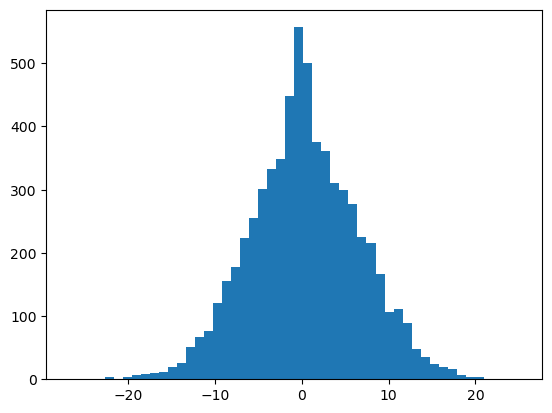

In [29]:
plt.hist(hpreact.view(-1).tolist(), 50)

(array([2165.,  152.,   94.,   59.,   51.,   49.,   48.,   36.,   35.,
          33.,   42.,   31.,   45.,   30.,   37.,   24.,   17.,   19.,
          21.,   14.,   28.,   17.,   12.,   22.,   34.,   20.,   22.,
          15.,    8.,   26.,   23.,   22.,   24.,   28.,   40.,   15.,
          23.,   36.,   20.,   27.,   21.,   25.,   30.,   53.,   45.,
          64.,   64.,   88.,  115., 2431.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

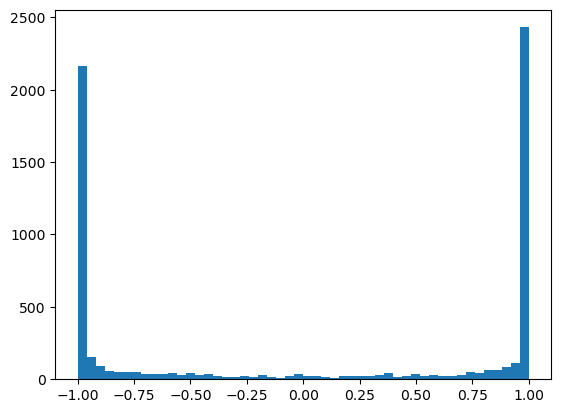

In [28]:
plt.hist(h.view(-1).tolist(), 50)

## hidden layer values issue 

In [ ]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd),          generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) * 0.12
B1 = torch.randn(n_hidden,                      generator=gen) * 0 
W2 = torch.randn((n_hidden, Vocab_size),        generator=gen) * 0.01
B2 = torch.randn((Vocab_size),                   generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 11897


In [38]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    # break

      0/ 200000: 3.3084
  10000/ 200000: 2.1916
  20000/ 200000: 2.2645
  30000/ 200000: 2.4685
  40000/ 200000: 1.9694
  50000/ 200000: 2.2938
  60000/ 200000: 2.4701
  70000/ 200000: 2.1093
  80000/ 200000: 2.2532
  90000/ 200000: 2.0789
 100000/ 200000: 1.8481
 110000/ 200000: 2.2240
 120000/ 200000: 1.8404
 130000/ 200000: 2.3603
 140000/ 200000: 2.2797
 150000/ 200000: 2.1542
 160000/ 200000: 1.8737
 170000/ 200000: 1.7337
 180000/ 200000: 1.9251
 190000/ 200000: 1.8048


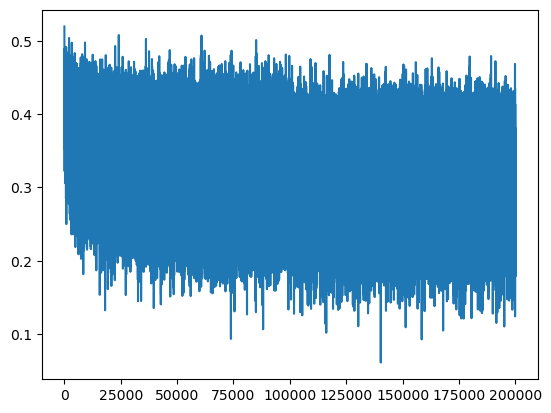

In [39]:
plt.plot(losses)

In [40]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.0477452278137207
dev 2.1037673950195312


(array([  1.,   1.,   1.,   1.,   0.,   2.,   4.,   4.,   2.,  10.,  11.,
         20.,  22.,  42.,  60.,  58.,  92., 123., 180., 216., 309., 393.,
        502., 586., 747., 700., 532., 385., 343., 258., 212., 145., 119.,
         75.,  65.,  45.,  38.,  24.,  23.,  16.,   9.,   8.,   8.,   2.,
          2.,   2.,   1.,   0.,   0.,   1.]),
 array([-4.23075151, -4.05878847, -3.88682543, -3.71486238, -3.54289934,
        -3.3709363 , -3.19897326, -3.02701021, -2.85504717, -2.68308413,
        -2.51112108, -2.33915804, -2.167195  , -1.99523195, -1.82326891,
        -1.65130587, -1.47934282, -1.30737978, -1.13541674, -0.96345369,
        -0.79149065, -0.61952761, -0.44756456, -0.27560152, -0.10363848,
         0.06832457,  0.24028761,  0.41225065,  0.5842137 ,  0.75617674,
         0.92813978,  1.10010283,  1.27206587,  1.44402891,  1.61599195,
         1.787955  ,  1.95991804,  2.13188108,  2.30384413,  2.47580717,
         2.64777021,  2.81973326,  2.9916963 ,  3.16365934,  3.33562239,
 

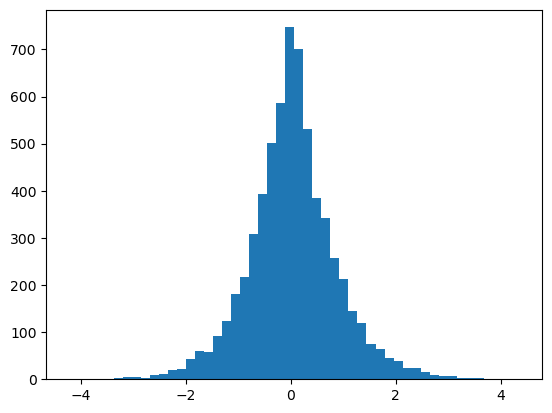

In [34]:
plt.hist(hpreact.view(-1).tolist(), 50)

(array([ 95., 115.,  84.,  92., 101.,  99., 111.,  94., 113., 115., 113.,
        118., 103., 137., 132., 109., 138., 157., 128., 126., 138., 149.,
        178., 146., 170., 199., 174., 170., 172., 171., 149., 149., 116.,
        150., 130., 121., 107., 125., 125., 127., 109., 124., 106., 126.,
        104., 107., 108., 115., 118., 137.]),
 array([-9.99577165e-01, -9.59592056e-01, -9.19606948e-01, -8.79621840e-01,
        -8.39636731e-01, -7.99651623e-01, -7.59666514e-01, -7.19681406e-01,
        -6.79696298e-01, -6.39711189e-01, -5.99726081e-01, -5.59740973e-01,
        -5.19755864e-01, -4.79770756e-01, -4.39785647e-01, -3.99800539e-01,
        -3.59815431e-01, -3.19830322e-01, -2.79845214e-01, -2.39860106e-01,
        -1.99874997e-01, -1.59889889e-01, -1.19904780e-01, -7.99196720e-02,
        -3.99345636e-02,  5.05447388e-05,  4.00356531e-02,  8.00207615e-02,
         1.20005870e-01,  1.59990978e-01,  1.99976087e-01,  2.39961195e-01,
         2.79946303e-01,  3.19931412e-01,  3.59916

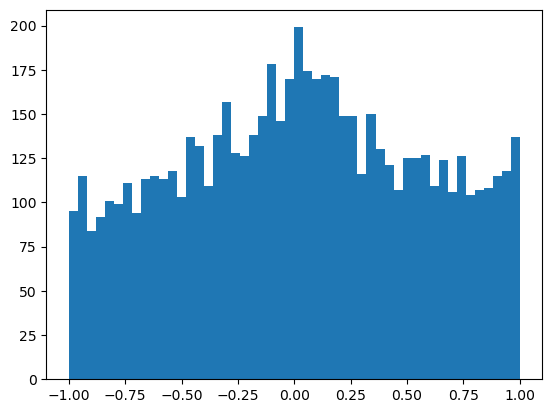

In [35]:
plt.hist(h.view(-1).tolist(), 50)

## setting initialization scales

#### checking the gaussian

tensor(-0.0020) tensor(1.0010)
tensor(-0.0020) tensor(1.0114)


(array([1.99287611e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 7.97150445e-05, 7.97150445e-05, 1.79358850e-04,
        3.38788939e-04, 2.79002656e-04, 9.76509295e-04, 1.81351726e-03,
        2.31173629e-03, 5.18147789e-03, 8.05121949e-03, 1.33522700e-02,
        2.19017085e-02, 3.62304877e-02, 5.65578241e-02, 8.48168074e-02,
        1.28640153e-01, 1.77206544e-01, 2.48212720e-01, 3.13598985e-01,
        3.73763915e-01, 4.10333192e-01, 4.19201490e-01, 3.96502631e-01,
        3.44827354e-01, 2.81812611e-01, 2.12241306e-01, 1.54447899e-01,
        1.06678658e-01, 7.18631126e-02, 4.52980740e-02, 2.78803368e-02,
        1.61622253e-02, 1.02633120e-02, 6.15798719e-03, 3.38788939e-03,
        2.45123762e-03, 1.25551195e-03, 5.97862834e-04, 3.58717700e-04,
        2.59073895e-04, 9.96438056e-05, 5.97862834e-05, 0.00000000e+00,
        0.00000000e+00, 1.99287611e-05]),
 array([-6.59002304, -6.33912937, -6.0882357 , -5.83734203, -5.58644836,
        -5.3355547 , 

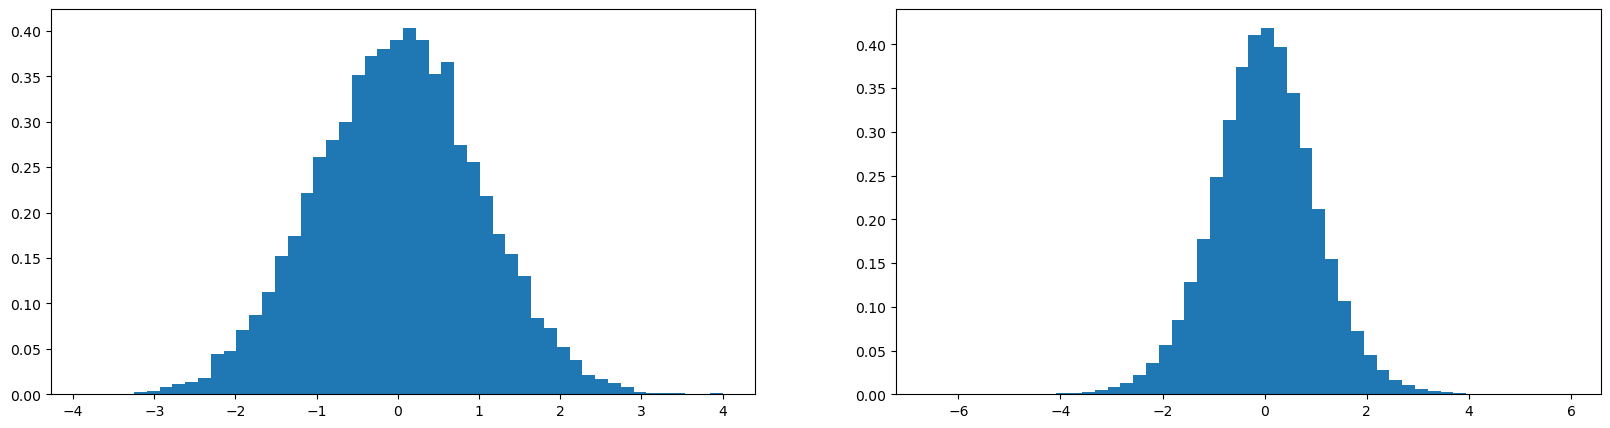

In [62]:
x = torch.randn(1000, 10)
w= torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

#### initialize weights

In [ ]:
scale = (5/3)/(30) **5   # for tanh activation
scale

6.858710562414266e-08

In [ ]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd),          generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
B1 = torch.randn(n_hidden,                      generator=gen) * 0.01
W2 = torch.randn((n_hidden, Vocab_size),        generator=gen) * 0.01
B2 = torch.randn((Vocab_size),                   generator=gen) * 0

parameters = [Cntx, W1, B1, W2, B2]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 11897


In [67]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    # break

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


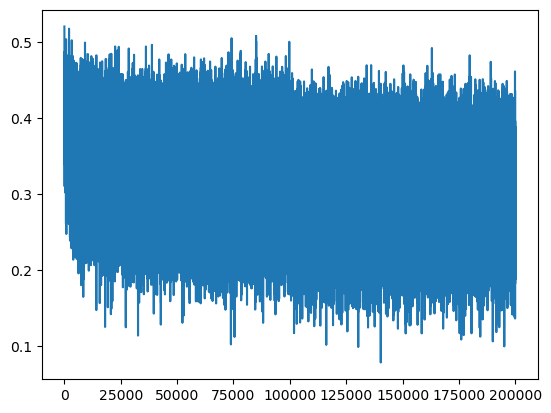

In [68]:
plt.plot(losses)

In [69]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.0376646518707275
dev 2.106989622116089


## Batch normalization

In [72]:
hpreact.shape

torch.Size([32, 200])

In [74]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [75]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [83]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd),          generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
B1 = torch.randn(n_hidden,                      generator=gen) * 0.01
W2 = torch.randn((n_hidden, Vocab_size),        generator=gen) * 0.01
B2 = torch.randn((Vocab_size),                   generator=gen) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [Cntx, W1, B1, W2, B2, bngain, bnbias]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 12297


In [84]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    # batch normalization
    hpreact = bngain * (hpreact - bnmeani)/(bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running =(0.999 * bnmean_running)  + (0.001 * bnmeani)
        bnstd_running = (0.999 * bnstd_running)  + (0.001 * bnstdi)
    
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    # break

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


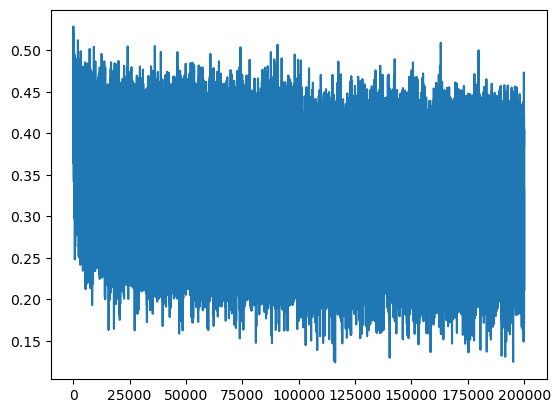

In [85]:
plt.plot(losses)

In [86]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    
    #estimate the mean and std values after training
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [88]:
bnmean

tensor([[-2.4421e+00,  7.7882e-01, -4.2867e-01,  1.0097e+00,  1.2232e+00,
          7.1535e-01,  2.0125e+00, -2.2497e+00,  1.8858e-01,  1.8270e+00,
         -1.7165e+00, -2.4228e+00, -4.6981e-01, -3.4039e-01,  2.2100e-02,
         -1.5466e+00,  5.6142e-01, -2.8754e+00,  3.6283e-01,  1.2172e+00,
         -4.0086e-01, -2.0382e-02,  3.8980e-01,  4.6630e-01,  1.0093e+00,
          1.1168e+00,  2.4125e+00,  6.9444e-01,  6.6025e-01,  2.3576e+00,
         -7.9830e-01, -5.6000e-01, -7.0886e-01, -7.4042e-01, -9.0137e-01,
         -1.3170e+00, -1.7872e-01,  3.5405e-01, -8.2059e-01,  7.5098e-01,
         -6.0459e-01, -1.8786e+00, -3.3827e-02, -1.3455e-01,  2.2539e-01,
          3.0648e-01,  1.8968e+00, -1.6248e+00,  1.5794e+00,  1.9369e+00,
          5.9906e-01, -2.9821e-01,  1.9606e+00,  6.0573e-01,  9.6431e-01,
         -1.2451e+00,  2.3114e-01,  3.1679e-01,  1.6356e+00, -9.2572e-01,
         -6.4949e-01,  1.6722e+00,  3.5112e-01,  8.8244e-01,  5.7035e-01,
          5.8725e-01, -9.2215e-01,  2.

In [89]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1356,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1550,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3817, -1.0699, -0.0781,  0.3370, -0.5769,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6877,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8613,  0.8117,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6000,
          1.5853,  1.2103, -1.0171,  2.1421, -0.6330,  0.1071, -0.2926, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2401,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1928, -0.3261,  

In [ ]:
# beacuse of the bnmean_running values are similar to bnmean values then the calibration 
# after trainng is not necessary

In [91]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/(hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.06659197807312
dev 2.1050572395324707


### Because of the batch normalization has a bias(bnbias) parameter so the B1 is redundant

In [101]:
n_embd = 10
n_hidden = 200

# parameters
gen = torch.Generator().manual_seed(2147483647)
Cntx = torch.randn((Vocab_size,n_embd),          generator=gen)   
W1 = torch.randn((n_embd*block_size, n_hidden), generator=gen) * (5/3) / ((block_size* n_embd)**0.5)
# B1 = torch.randn(n_hidden,                      generator=gen) * 0.01
W2 = torch.randn((n_hidden, Vocab_size),        generator=gen) * 0.01
B2 = torch.randn((Vocab_size),                   generator=gen) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)

bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [Cntx, W1, W2, B2, bngain, bnbias]
print(f"number of parameters : {sum(parameter.nelement() for parameter in parameters)}")

for p in parameters:
    p.requires_grad = True

number of parameters : 12097


In [102]:
max_steps = 200000
batch_size = 32
losses = []


for i in range(max_steps):
    
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=gen)
    Xb , Yb = Xtr[idx], Ytr[idx]
    
    embd = Cntx[Xb]
    embcat = embd.view(embd.shape[0], -1)
    hpreact = (embcat @ W1) 
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    
    # batch normalization
    hpreact = bngain * (hpreact - bnmeani)/(bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running =(0.999 * bnmean_running)  + (0.001 * bnmeani)
        bnstd_running = (0.999 * bnstd_running)  + (0.001 * bnstdi)
    
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    for p in parameters:
        p.grad = None
        
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.01 # learning rate decay

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    losses.append(loss.log10().item())
    # break

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


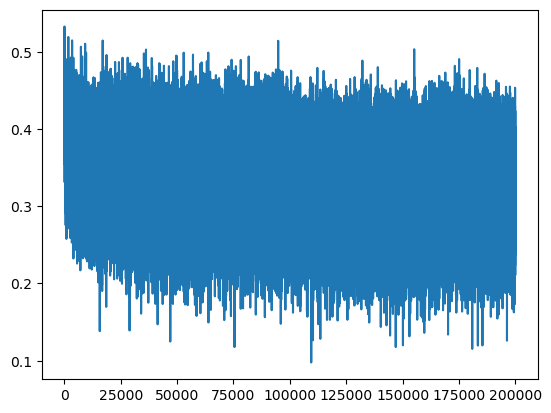

In [103]:
plt.plot(losses)

In [104]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev' : (Xdev, Ydev),
        'test' : (Xte, Yte),
    }[split]
    emb = Cntx[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = (embcat @ W1) + B1
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/(hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean_running)/bnstd_running + bnbias
    
    h = torch.tanh(hpreact)
    logits = (h @ W2) + B2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('dev')

train 2.0674195289611816
dev 2.105670690536499


###  Build operations similar to pytorch

In [105]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=gen)/ (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight, self.bias] if self.bias is not None else [self.weight]

In [106]:
class BatchNorm1d:
    def __init__(self, dim, momentum=0.1, eps=1e-5):

        self.momentum = momentum
        self.eps = eps
        self.training = True
        
        # parameters : trained with backpro
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers : trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)              # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
            
        else: 
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta              # scale and shift
        
        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]   

In [107]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

### Checking for tanh layers

In [139]:
n_embd = 10 
n_hidden = 100 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((Vocab_size, n_embd),   generator=g)

layers = [
      Linear(n_embd * block_size, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, Vocab_size),
]

with torch.no_grad():
  layers[-1].weight  *= 0.1  # make last layer less confident
  
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3
  
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
  
for p in parameters:
  p.requires_grad = True


46497


In [140]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
      # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    # with torch.no_grad():
    #     ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2946


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 18.59%
layer 3 (      Tanh): mean +0.00, std 0.70, saturated: 10.91%
layer 5 (      Tanh): mean +0.01, std 0.66, saturated: 7.31%
layer 7 (      Tanh): mean +0.01, std 0.67, saturated: 6.16%
layer 9 (      Tanh): mean +0.01, std 0.65, saturated: 6.25%


Text(0.5, 1.0, 'activation distribution')

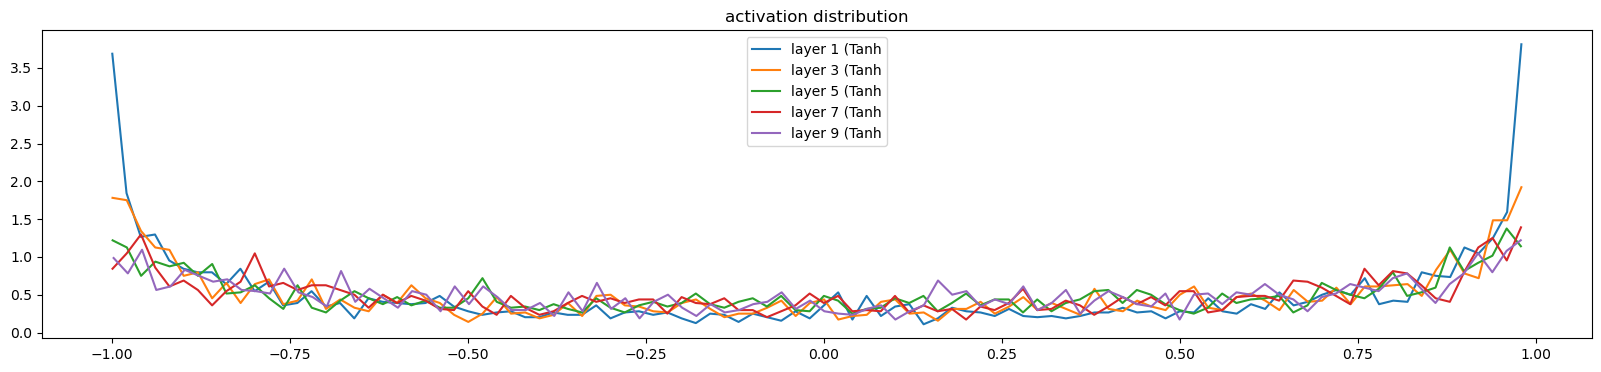

In [141]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000005, std 4.313475e-04
layer 3 (      Tanh): mean -0.000019, std 4.187435e-04
layer 5 (      Tanh): mean +0.000004, std 3.779267e-04
layer 7 (      Tanh): mean +0.000018, std 3.452357e-04
layer 9 (      Tanh): mean +0.000005, std 3.134392e-04


Text(0.5, 1.0, 'gradient distribution')

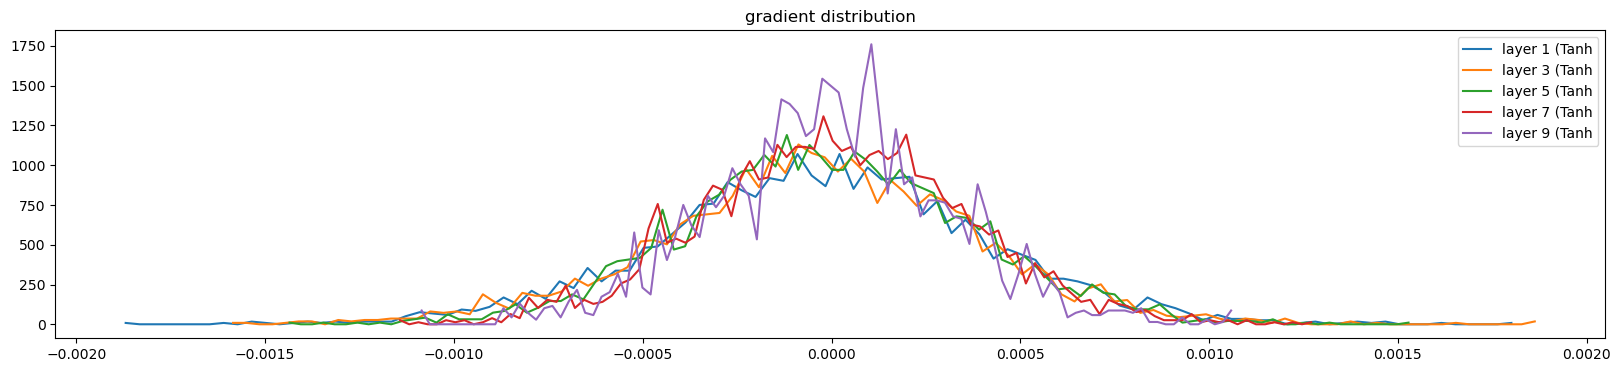

In [142]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### Checking for linear layers

In [147]:
n_embd = 10 
n_hidden = 100 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((Vocab_size, n_embd),   generator=g)

layers = [
      Linear(n_embd * block_size, n_hidden), #Tanh(),
      Linear(           n_hidden, n_hidden), #Tanh(),
      Linear(           n_hidden, n_hidden), #Tanh(),
      Linear(           n_hidden, n_hidden), #Tanh(),
      Linear(           n_hidden, n_hidden), #Tanh(),
      Linear(           n_hidden, Vocab_size),
]

with torch.no_grad():
  layers[-1].weight  *= 0.1  # make last layer less confident
  
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  1
      
  
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
  
for p in parameters:
  p.requires_grad = True

46497


In [148]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
      # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break
    # with torch.no_grad():
    #     ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3060


layer 0 (    Linear): mean +0.01, std 0.96, saturated: 31.28%
layer 1 (    Linear): mean +0.07, std 0.93, saturated: 30.38%
layer 2 (    Linear): mean +0.08, std 0.94, saturated: 27.59%
layer 3 (    Linear): mean +0.03, std 0.98, saturated: 31.16%
layer 4 (    Linear): mean -0.02, std 0.99, saturated: 30.34%


Text(0.5, 1.0, 'activation distribution')

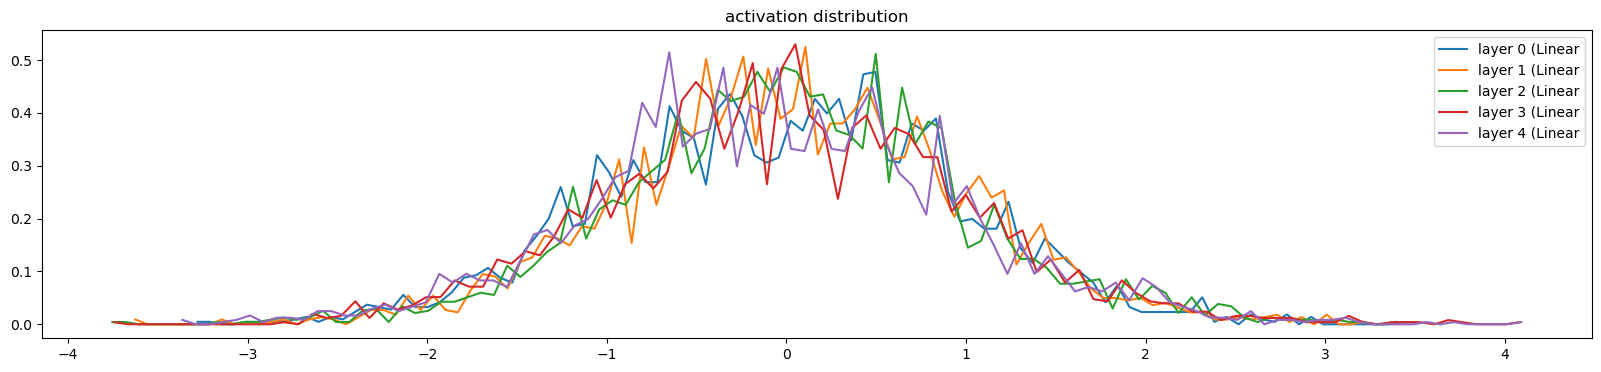

In [149]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 0 (    Linear): mean +0.000001, std 3.180902e-04
layer 1 (    Linear): mean +0.000018, std 3.188558e-04
layer 2 (    Linear): mean +0.000008, std 3.224831e-04
layer 3 (    Linear): mean +0.000003, std 3.179839e-04
layer 4 (    Linear): mean +0.000000, std 3.076392e-04


Text(0.5, 1.0, 'gradient distribution')

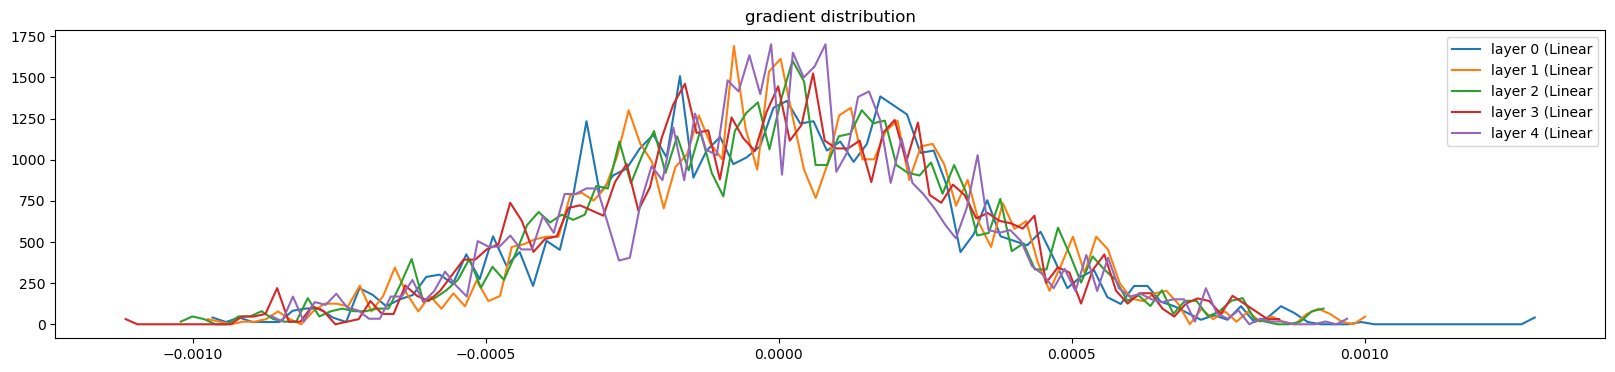

In [150]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

## network with tanh

In [163]:
n_embd = 10 
n_hidden = 100 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((Vocab_size, n_embd),   generator=g)

layers = [
      Linear(n_embd * block_size, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), Tanh(),
      Linear(           n_hidden, Vocab_size),
]

with torch.no_grad():
  layers[-1].weight  *= 0.1  # make last layer less confident
  
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3
  
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
  
for p in parameters:
  p.requires_grad = True

46497


In [169]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
      # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.0993


layer 1 (      Tanh): mean -0.03, std 0.75, saturated: 18.41%
layer 3 (      Tanh): mean +0.04, std 0.73, saturated: 13.59%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 13.72%
layer 7 (      Tanh): mean -0.02, std 0.74, saturated: 12.69%
layer 9 (      Tanh): mean -0.03, std 0.72, saturated: 11.69%


Text(0.5, 1.0, 'activation distribution')

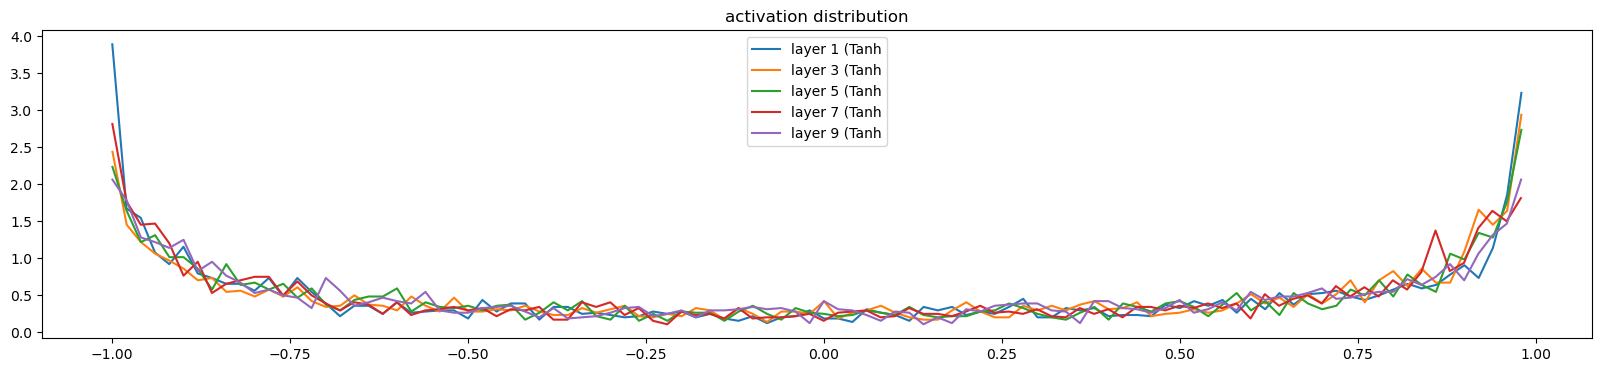

In [170]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000032, std 3.013920e-03
layer 3 (      Tanh): mean +0.000001, std 2.761696e-03
layer 5 (      Tanh): mean -0.000048, std 2.724309e-03
layer 7 (      Tanh): mean +0.000016, std 2.653009e-03
layer 9 (      Tanh): mean -0.000030, std 2.400407e-03


Text(0.5, 1.0, 'gradient distribution')

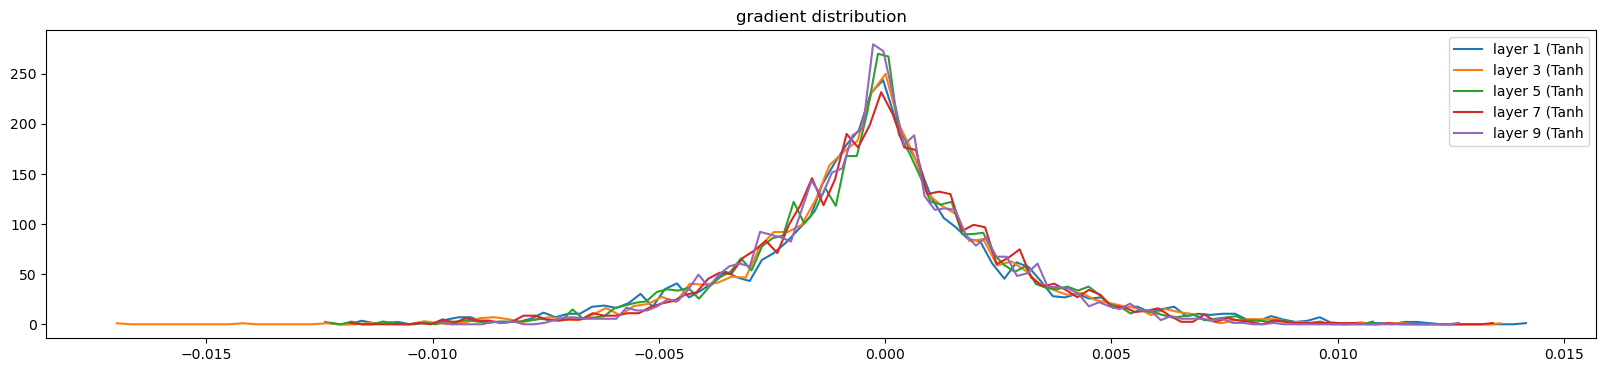

In [171]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000755 | std 1.298116e-02 | grad:data ratio 1.293995e-02
weight  (30, 100) | mean -0.000015 | std 9.745342e-03 | grad:data ratio 3.171028e-02
weight (100, 100) | mean +0.000031 | std 7.251548e-03 | grad:data ratio 4.195171e-02
weight (100, 100) | mean -0.000005 | std 6.847430e-03 | grad:data ratio 4.051724e-02
weight (100, 100) | mean -0.000007 | std 6.290972e-03 | grad:data ratio 3.722592e-02
weight (100, 100) | mean +0.000020 | std 5.614516e-03 | grad:data ratio 3.335779e-02
weight  (100, 27) | mean +0.000000 | std 2.223922e-02 | grad:data ratio 2.745017e-01


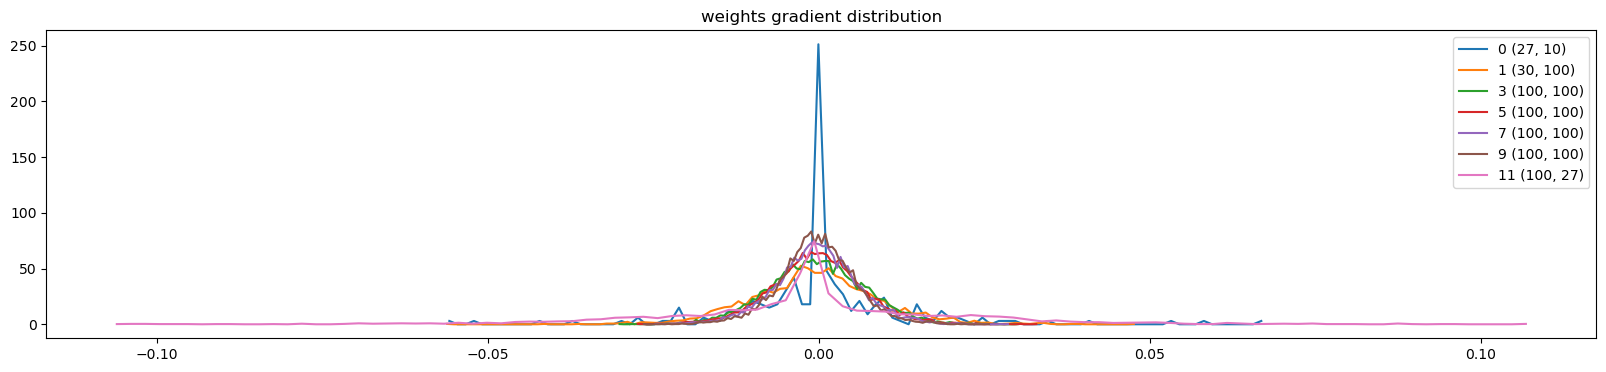

In [172]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

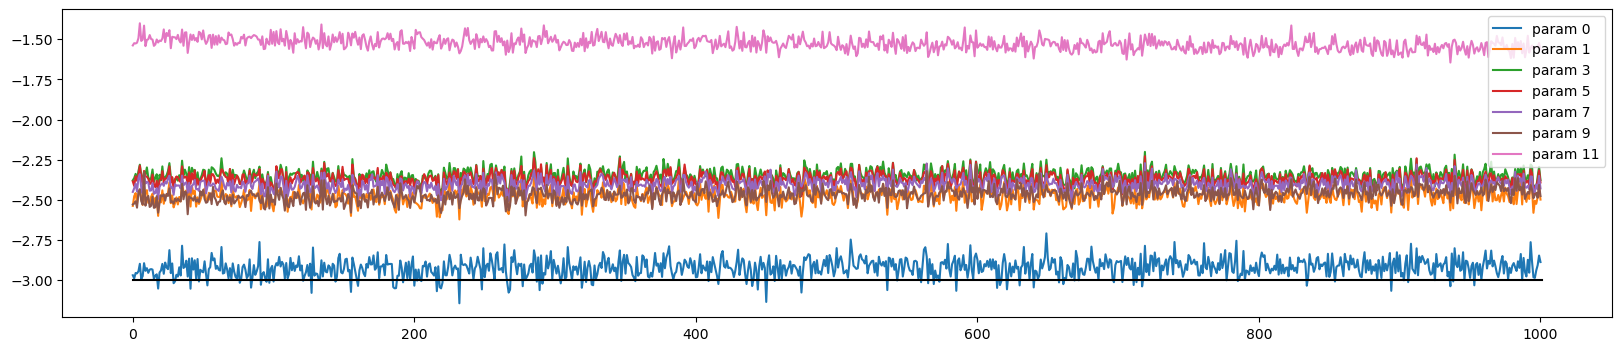

In [173]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)


### Include Batch Normalization

In [174]:
n_embd = 10 
n_hidden = 100 
g = torch.Generator().manual_seed(2147483647) 

C = torch.randn((Vocab_size, n_embd),   generator=g)

layers = [
      Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
      Linear(           n_hidden, Vocab_size), BatchNorm1d(Vocab_size),
]

with torch.no_grad():
  layers[-1].gamma  *= 0.1  # make last layer less confident
  
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3
  
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
  
for p in parameters:
  p.requires_grad = True

47551


In [175]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
      # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000:
        break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3175


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 3.31%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.84%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.41%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.97%


Text(0.5, 1.0, 'activation distribution')

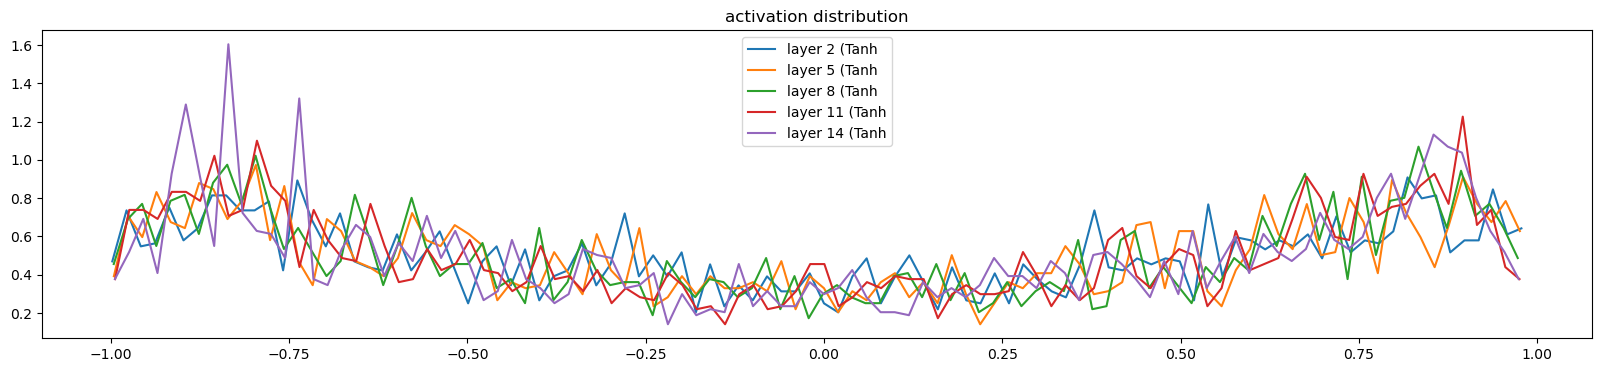

In [176]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.076676e-03
layer 5 (      Tanh): mean -0.000000, std 2.639548e-03
layer 8 (      Tanh): mean +0.000000, std 2.627528e-03
layer 11 (      Tanh): mean -0.000000, std 2.468886e-03
layer 14 (      Tanh): mean +0.000000, std 2.447739e-03


Text(0.5, 1.0, 'gradient distribution')

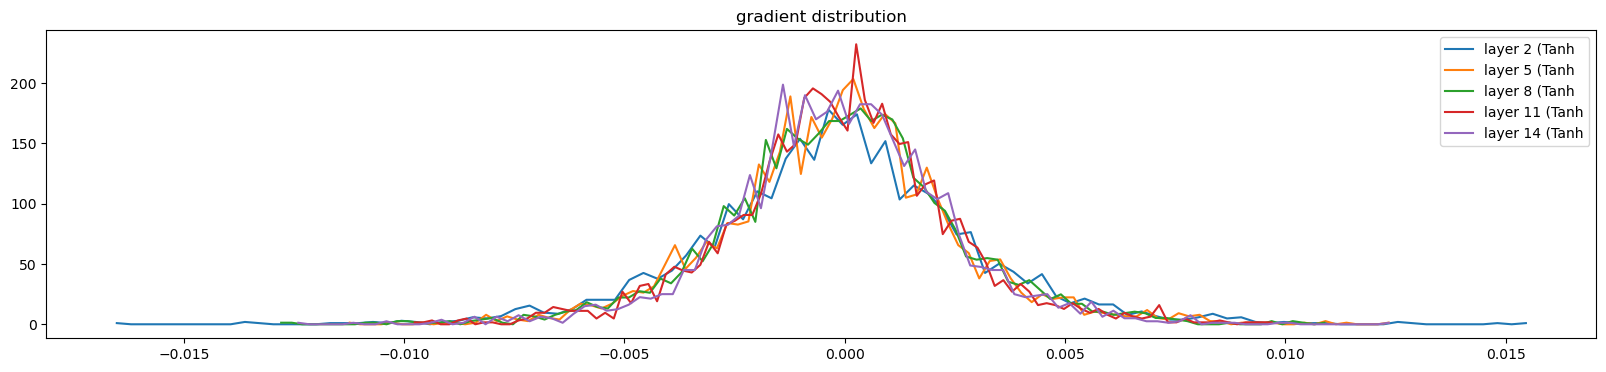

In [177]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.567476e-03 | grad:data ratio 8.558805e-03
weight  (30, 100) | mean +0.000072 | std 6.922877e-03 | grad:data ratio 2.287582e-02
weight (100, 100) | mean +0.000134 | std 5.822403e-03 | grad:data ratio 3.485772e-02
weight (100, 100) | mean -0.000047 | std 5.076732e-03 | grad:data ratio 3.041168e-02
weight (100, 100) | mean -0.000045 | std 5.104857e-03 | grad:data ratio 3.049113e-02
weight (100, 100) | mean +0.000037 | std 4.739982e-03 | grad:data ratio 2.809389e-02
weight  (100, 27) | mean +0.000015 | std 8.436492e-03 | grad:data ratio 5.072391e-02


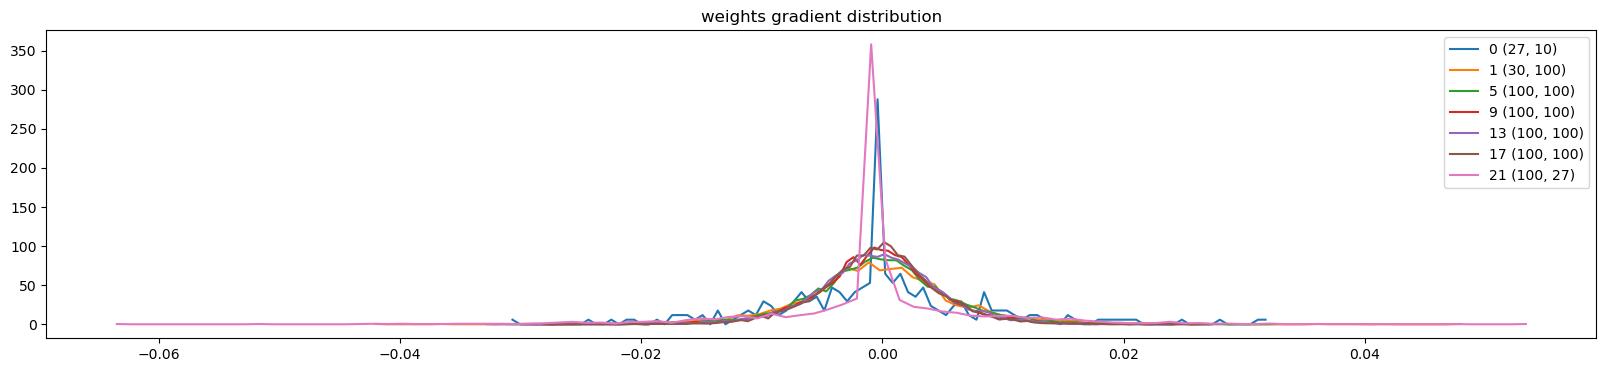

In [178]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

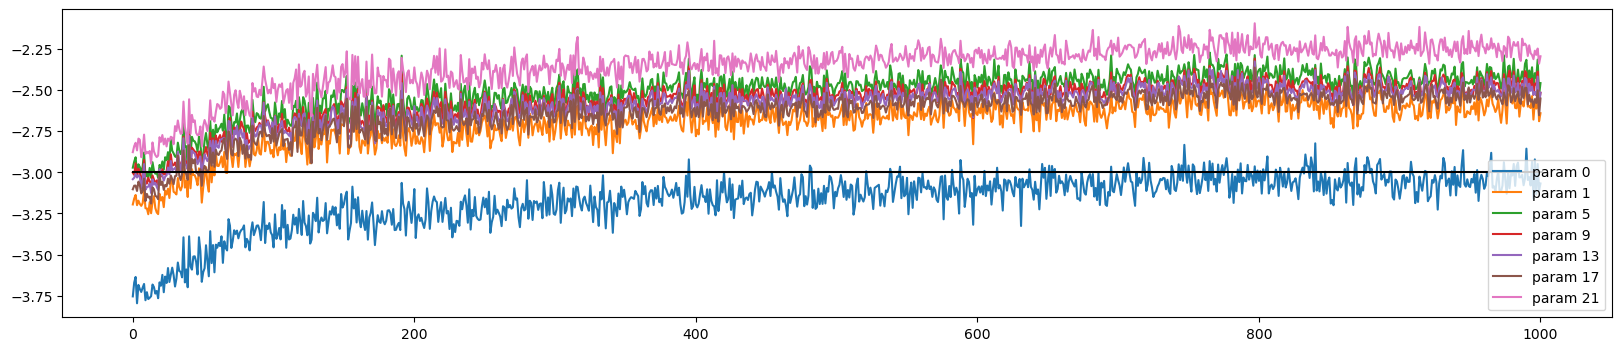

In [179]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [180]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'dev': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('dev')

train 2.4165303707122803
dev 2.4132325649261475


In [181]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in out)) # decode and print the generated word

mria.
mmyan.
seen.
ndhnyah.
rethrs.
ejdrleg.
adejedieliie.
miloen.
eden.
van.
nar.
katzior.
kaa.
noshdbergihiries.
janie.
jelioxnteuofiu.
maned.
riy.
julyeh.
ylie.
